In [16]:
import os
from datetime import datetime

from engioptiqa import AnnealingSolverDWave, DesignOptimizationProblem, Rod1D
from matplotlib import pyplot as plt
import numpy as np


In [17]:
def save_best_solutions(problem, criterion_name, solutions, n_max=3, output_path=None, suffix=''):

    if criterion_name == 'error_l2_rel': 
        criterion = problem.errors_l2_rel 
    elif criterion_name == 'error_h1_rel':
        criterion = problem.errors_h1_rel
    elif criterion_name == 'objective':
        criterion = problem.objectives
    elif criterion_name == 'error_comp_energy':
        criterion = problem.errors_comp_energy_rel
    else:
        raise Exception('Unknown criterion name', criterion_name)
    
    i_min =np.argsort(criterion)

    for i, i_sol in enumerate(i_min):
        if i > n_max:
            break
        solution = solutions[i_sol]
        error_l2 = problem.errors_l2_rel[i_sol]
        error_h1 = problem.errors_h1_rel[i_sol]
        objective = problem.objectives[i_sol]
        comp_energy = problem.comp_energies[i_sol]
        error_comp_energy_rel =  problem.errors_comp_energy_rel[i_sol]
        cs = problem.cs[i_sol]
        subtitle = f'Design: {cs} Optimal: {problem.A_analytic}'
        subtitle+= f'\nL2-Error: {error_l2:.4e}'
        subtitle+= f'\nH1-Error: {error_h1:.4e}'
        subtitle+= f'\nObjective: {objective:.4e}'
        subtitle+= f'\nComp. Energy: {comp_energy:.6f} (e={error_comp_energy_rel:.3e})' 
        subtitle+= f'\nComp. Energy Analytic {problem.PI_analytic:.6f}'
        subtitle+= f'\nConstraints: {solution["constraints"]}'
        problem.plot_force(
            problem.force_analytic, 
            solution['force'], 
            subtitle=subtitle,
            file_name = os.path.join(output_path, suffix+criterion_name+f'_{i}'),
            save_fig = True,
            save_tikz = True
        )

# TODO: Handle path in JupyterLab

In [18]:
notebook_path = os.path.abspath("")
notebook_directory = os.path.dirname(notebook_path)
notebook_directory = '/usr2/key/Projects/QuantumAnnealing/CISM'
print(notebook_path)
print(notebook_directory)

/usr2/key/Projects/QuantumAnnealing/EngiOptiQA
/usr2/key/Projects/QuantumAnnealing/CISM


In [19]:
# Create an output folder with current time stamp.
timestamp = datetime.now().strftime("%Y_%m_%d_%H-%M-%S")
output_path = f"{timestamp}_output"
output_path = os.path.join(notebook_directory, output_path)
os.makedirs(output_path)

output_path_amplify = os.path.join(output_path,'amplify')
output_path_dwave = os.path.join(output_path,'dwave')


# Solving a Design Optimization Problem with EngiOptiQA

In this notebook, you can solve the design optimization problem presented in [Key and Freinberger (2024)](https://doi.org/10.3390/math12030482) using *Simulated Annealing (SA)*.

## Suggested Steps
   1. Reproduce the results from the paper
   2. Study the effect of changing 
      - the number of qubits for representig the real-valued variables (`n_qubits_per_node`)
      - the penalty weight for the constraint of static admissibility (`penalty_weight_dwave`)
      - the number of runs of the simulated annealing algorithm (`num_reads`)
      - the number of rod components (`n_comp`)
      - ...


## The Design Optimization Problem

In [20]:
# Define the design optimization problem for a one-dimensional rod under self-weight loading through body force density g.
g = 1.5
# Rod with n_comp components and of length L.
n_comp = 2; L = 1.5; A_choices = [0.25, 0.5]; rod_1d = Rod1D(n_comp, L)

In [21]:
optimization_problem_dwave = DesignOptimizationProblem(rod_1d, g, A_choice=A_choices, output_path=output_path_dwave)

Folder '/usr2/key/Projects/QuantumAnnealing/CISM/2025_04_24_14-20-10_output/dwave' created successfully.
Design Optimization Problem



### Analytical Solution

+----------------+----------------------+-------------------+
| Cross Sections | Complementary Energy |     Compliance    |
+----------------+----------------------+-------------------+
|  (0.5, 0.25)   |  0.296630859375000   | 0.593261718750000 |
|  (0.25, 0.25)  |  0.316406250000000   | 0.632812500000000 |
|   (0.5, 0.5)   |  0.632812500000000   |  1.26562500000000 |
|  (0.25, 0.5)   |  0.830566406250000   |  1.66113281250000 |
+----------------+----------------------+-------------------+

Optimal Solution:
	Cross Section: (0.5, 0.25)
	Complementary Energy: 0.296630859375000
	Compliance: 0.593261718750000

Analytic Force: [0.84375 - 0.75*x, 0.5625 - 0.375*x]



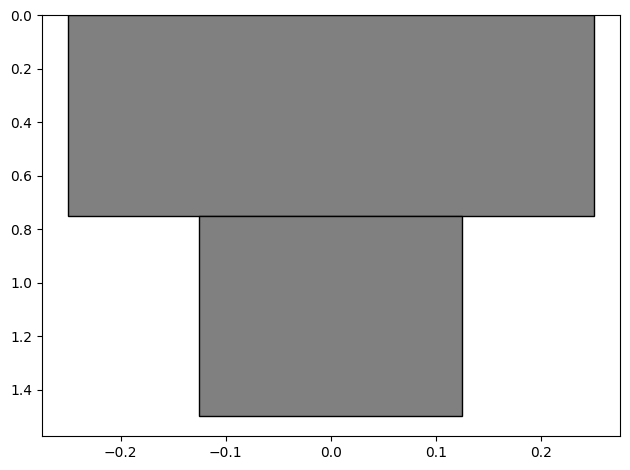

In [22]:
# Compute analytical solution.
optimization_problem_dwave.compute_analytical_solution()

### Numerical Solution

#### DWave

# TODO Remove token files when running in JupyterLab

In [23]:
# Setup the annealing solvers.
token_files = {
    'DWave': None,
    }
proxy='http://proxy.ilsb.tuwien.ac.at:3128'

annealing_solver_dwave = AnnealingSolverDWave(token_files['DWave'], proxy=proxy)
annealing_solver_dwave.setup_solver(solver_type='simulated_annealing')

Use simulated_annealing solver: simulated annealing


#### Discretization through Real-Valued Nodal Coefficients

In [24]:
# Discretization.
binary_representation = 'normalized'
n_qubits_per_node = 3

optimization_problem_dwave.generate_discretization(n_qubits_per_node, binary_representation)

#### QUBO Formulation

In [25]:
# QUBO formulation.
penalty_weight_dwave = 5.0
optimization_problem_dwave.generate_qubo_formulation(penalty_weight=penalty_weight_dwave)

optimization_problem_dwave.visualize_qubo_matrix_pattern(save_fig=True, save_tikz=False)
optimization_problem_dwave.visualize_qubo_matrix_sub_pattern(save_fig=True, save_tikz=False)

Effective penalty weight: 5.0

Number of input qubits: 8
Number of logical qubits: 26



#### Transform the Problem from the Amplify SDK to the DWave SDK

In [26]:
# Transform Amplify problem for DWave
lp_file_name = 'design_optimization_problem_sa.lp'
lp_file_path = os.path.join(output_path, lp_file_name)
optimization_problem_dwave.transform_to_dwave(lp_file_path)

#### Perform the Annealing

In [27]:
# Solve problem.
annealing_solver_dwave.solve_qubo_problem(
    optimization_problem_dwave,
    num_reads=10,
    label = f"Design Optimization Problem SA",
    )

Number of solutions: 10


#### Analyze the Raw Results

In [28]:
# Analyze raw results
solutions_dwave = optimization_problem_dwave.analyze_results(result_max=0)

Best solution (minimum objective):
L2 Error 0.015873015873015817 0.015873015873015817
H1 Error 0.015873015873015817 0.015873015873015817



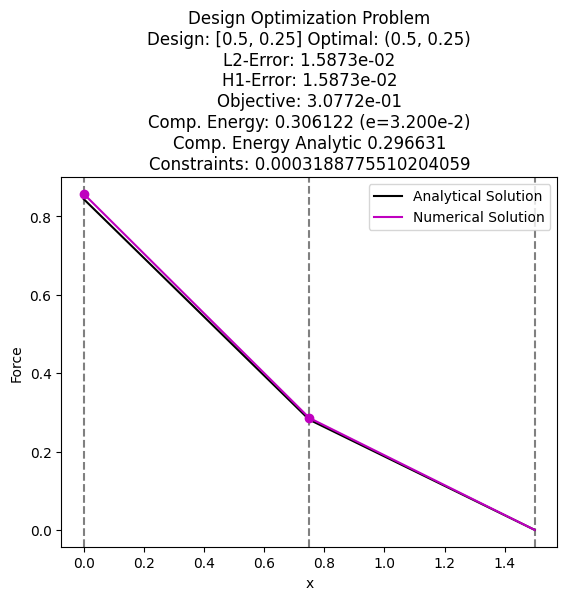

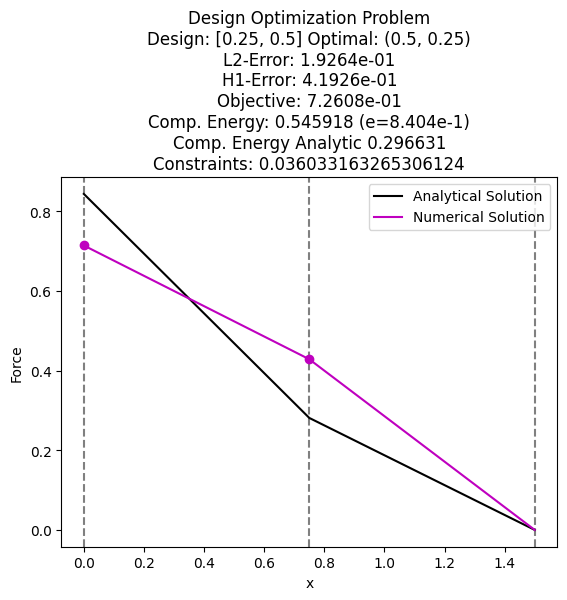

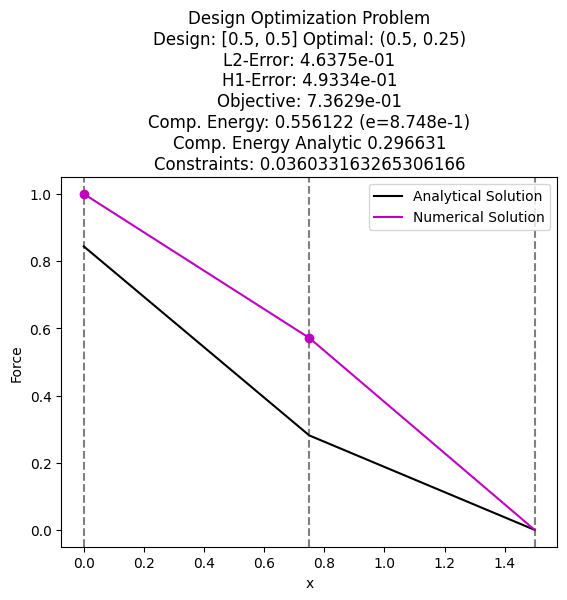

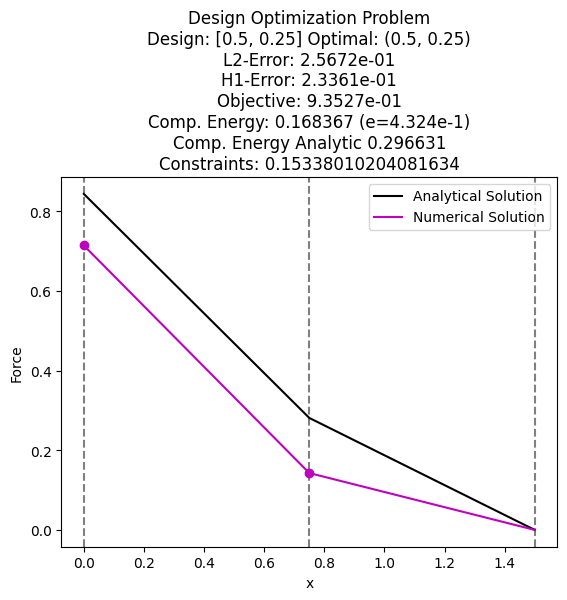

In [29]:
save_best_solutions(optimization_problem_dwave, 'objective', solutions_dwave, output_path=output_path_dwave)